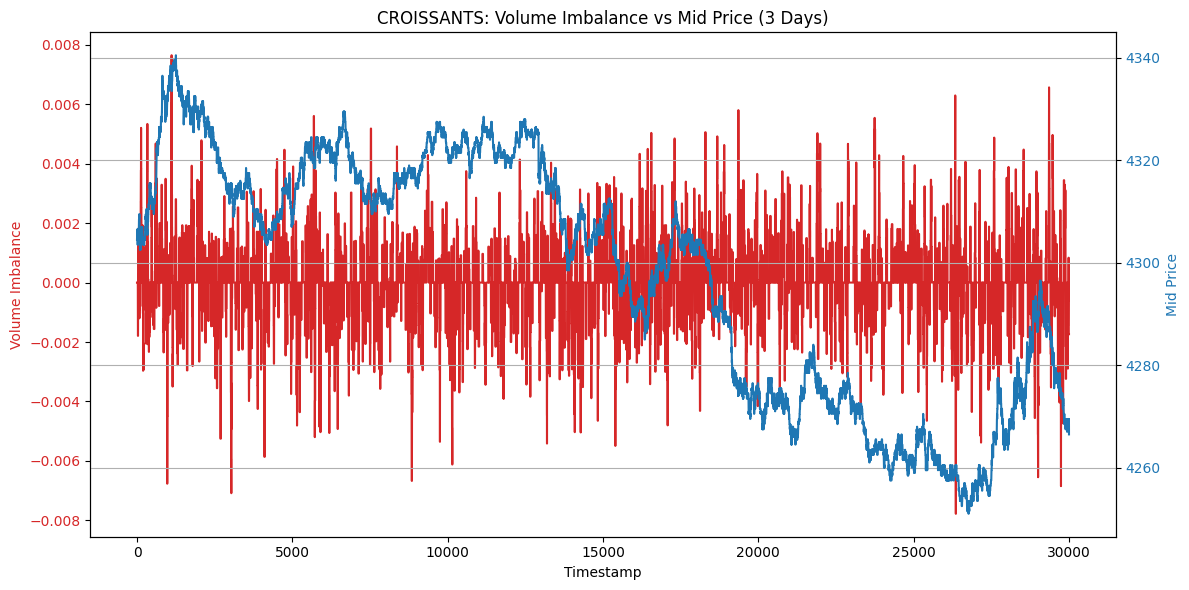

In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Load CSVs
df_day_minus1 = pd.read_csv("prices_round_2_day_-1.csv", delimiter=";")
df_day_0 = pd.read_csv("prices_round_2_day_0.csv", delimiter=";")
df_day_1 = pd.read_csv("prices_round_2_day_1.csv", delimiter=";")

# Process CROISSANTS data
def process_day(df):
    # Filter only CROISSANTS
    df = df[df["product"] == "CROISSANTS"].copy()
    
    # Fill missing volume values with 0
    volume_cols = ["bid_volume_1", "bid_volume_2", "bid_volume_3",
                   "ask_volume_1", "ask_volume_2", "ask_volume_3"]
    df[volume_cols] = df[volume_cols].fillna(0)

    # Normalize timestamps within each day
    df["timestamp"] = range(len(df))
    
    # Compute total bid/ask volume
    df["total_bid"] = df["bid_volume_1"] + df["bid_volume_2"] + df["bid_volume_3"]
    df["total_ask"] = df["ask_volume_1"] + df["ask_volume_2"] + df["ask_volume_3"]

    # Compute volume imbalance safely
    denom = df["total_bid"] + df["total_ask"]
    df["vol_imbalance"] = np.where(
        denom != 0,
        (df["total_bid"] - df["total_ask"]) / denom,
        0  # or np.nan if you prefer to skip these
    )

    # Optional smoothing
    df["vol_imbalance_smooth"] = df["vol_imbalance"].rolling(window=20, min_periods=1).mean()
    
    return df[["timestamp", "vol_imbalance_smooth", "mid_price"]]

# Process each day and offset timestamps
df1 = process_day(df_day_minus1)
df2 = process_day(df_day_0)
df2["timestamp"] += len(df1)
df3 = process_day(df_day_1)
df3["timestamp"] += len(df1) + len(df2)

# Combine all three days
df_all = pd.concat([df1, df2, df3], axis=0).reset_index(drop=True)

# Plot
fig, ax1 = plt.subplots(figsize=(12, 6))

# Volume imbalance (left y-axis)
ax1.plot(df_all["timestamp"], df_all["vol_imbalance_smooth"], color="tab:red", label="Smoothed Volume Imbalance")
ax1.set_xlabel("Timestamp")
ax1.set_ylabel("Volume Imbalance", color="tab:red")
ax1.tick_params(axis="y", labelcolor="tab:red")

# Mid price (right y-axis)
ax2 = ax1.twinx()
ax2.plot(df_all["timestamp"], df_all["mid_price"], color="tab:blue", label="Mid Price")
ax2.set_ylabel("Mid Price", color="tab:blue")
ax2.tick_params(axis="y", labelcolor="tab:blue")

plt.title("CROISSANTS: Volume Imbalance vs Mid Price (3 Days)")
plt.grid(True)
plt.tight_layout()
plt.show()
